# Modules

In [ ]:
import time
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
import networkx as nx
from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.datasets import VOCSegmentation as VOC
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import average_precision_score
from heapq import heappush, heappop
from torchvision import transforms
import tensorflow_datasets as tfds
import torch.utils.data as data
import numpy as np
import scipy

# Setting Seed 

In [ ]:
SEED = 981126

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# This is a debugging notebook for the Randomly Wired Neural Network model


1.   Overall architecture of the model
2.   Node Operation
  *   Seperable Convolution
3.   Edge Operation
4.   Graph Contsruction
5.   Mapping the Graph onto the architectural computation method
  *   Make sure all the edges meet at the end
  *   Ensure that all the nodes are connected and directed
6.   Make unit testing functions to check the architecture works in general
7.   Data preprocessing functions

# Overall Architecture of the model
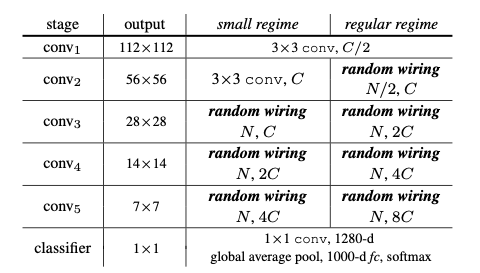

In [ ]:
class RandomlyWiredNeuralNetwork(nn.Module):

    def __init__(self, channel, input_channel, p, k, m, graph_type, classes, node_num, is_train=True, is_small_regime=True):
        """The base architecture of Randomly Wired Neural Network model.

           Args:
              channel(int): Number of initial output channels for generator.
              classes(int): Number of classes to classify.
              input_channel(int): Number of initial channels.
              node_num(int): Total number of nodes in the graph.
              conv_layers(Modules): Convolutional Neural Network Layers.
        """
        super(RandomlyWiredNeuralNetwork, self).__init__()
        self.channel = channel
        self.classes = classes
        self.input_channel = input_channel
        self.node_num = node_num

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=channel//2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channel//2)
            )
        
        if is_small_regime:
            self.conv2 = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(in_channels=channel//2, out_channels=channel, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(channel)
            )

            self.conv3 = Rand_Wire(node_num, p, k, m, graph_type, channel, channel, is_train, "small_regime_1")

            self.conv4 = Rand_Wire(node_num, p, k, m, graph_type, channel, 2*channel, is_train, "small_regime_2")
            
            self.conv5 = Rand_Wire(node_num, p, k, m, graph_type, 2*channel, 4*channel, is_train, "small_regime_3")

            self.conv6 = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(4*channel, 1280, 1),
                nn.BatchNorm2d(1280),
                nn.AdaptiveAvgPool2d(1)
            )
        else:
            self.conv2 = Rand_Wire(node_num, p, k, m, graph_type, channel//2, channel, is_train, "regular_regime_1")

            self.conv3 = Rand_Wire(node_num, p, k, m, graph_type, channel, 2*channel, is_train, "regular_regime_2")

            self.conv4 = Rand_Wire(node_num, p, k, m, graph_type, 2*channel, 4*channel, is_train, "regular_regime_3")

            self.conv5 = Rand_Wire(node_num, p, k, m, graph_type, 4*channel, 8*channel, is_train, "regular_regime_4")

            self.conv6 = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(8*channel, 1280, 1),
                nn.BatchNorm2d(1280),
                nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1280, classes),
            nn.LogSoftmax(1)
        )

        for parameter in self.parameters():
            if parameter.dim() >= 2:
                nn.init.xavier_uniform_(parameter)

    def forward(self, x):                             
       x = self.conv1(x)                              
       x = self.conv2(x)                              
       x = self.conv3(x)                              
       x = self.conv4(x)                              
       x = self.conv5(x)                              
       x = self.conv6(x).squeeze(-1).squeeze(-1)    
       x = self.classifier(x)                         

       return x

# Node Operation
  1.   Aggregation: The input data of one or more input edges to a node and are combined via a weighted sum; the weights are learnable and positive (use sigmoid on the weights to ensure positivity).
  2.   Transformation: After the aggregation, then the data is passed through a 3x3 sepearable convolution layer (ReLU -> Conv -> BN triplet). (ReLU is used to intake both positive and negative value so as to prevent large computational values.)
  3.   Distribution: After the Transformation, the copies of the processed data is then passed to the output edges.


In [ ]:
class Node(nn.Module):

    def __init__(self, in_channel, out_channel, degree=1, stride=1):
        """Node Operation defined by the paper.

           Node Operation:
            1. Aggregation of the input nodes.
            2. Transformation through the convolutional layers.

           Args:
              aggregate_weight(tensor): Weight to aggregate the node tensors.
              conv(Module): Convolutional layers defined by the paper.
              degree(int): The in_degree of the node.
              stride(int): The stride of the seperable conv layer.
        """
        super(Node, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.aggregate_weight = nn.Parameter(torch.zeros(degree), requires_grad=True).to(device)
        self.conv = nn.Sequential(
            nn.ReLU(),
            SeperableConvolution(in_channel, out_channel, stride),
            nn.BatchNorm2d(out_channel)
        )

    def forward(self, x):
        # x = [B, channel, W, H, degree]
        # aggregate weight = [degree, 1]
        x = torch.matmul(x, torch.sigmoid(self.aggregate_weight))
            
        # x = [B, channel, W, H]
        x = self.conv(x)

        return x

class SeperableConvolution(nn.Module):

    def __init__(self, in_channel, out_channel, stride=1):
        super(SeperableConvolution, self).__init__()
        """
        Seperable convolution defined by the paper.

        Combination of depthwise 3x3 convolution and 1x1 convolution would act 
        as convolution for each channels and then taking a channel-wise pooling.
        """
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, padding=1, stride=stride),
            nn.Conv2d(in_channel, out_channel, 1) 
        )

    def forward(self, x):
        # x = [B, C, W, H]
        return self.conv(x)

## Unit Test 

In [ ]:
def test_seperableConv():
    test = [(1,1), (3,4), (3,10)]
    for i in test:
      tensor = torch.randn((32, i[0], 96, 96), dtype=torch.float)
      sep_conv = SeperableConvolution(i[0], i[1])
      output = sep_conv(tensor)

      expected = torch.randn(32, i[1], 96, 96)

      assert output.shape == expected.shape

def test_node_operation():
    nod = Node(3, 4, 10)
    tensor = torch.stack([torch.randn((1, 3, 5, 5), dtype=torch.float) for _ in range(10)], -1)
    output = nod(tensor)

    expected = torch.randn(1, 4, 5, 5)

    assert output.shape == expected.shape


In [ ]:
test_seperableConv()
# test_node_operation()

# Edge Operation

The edge operation will be the forward function of the random graph generator.

# Graph Construction

*   Use networkx module to construct the random graph models
  *   Watts Strogatz (default)
  *   Erdos Renyi
  *   Barabasi Albert

* Input and output nodes: 
  * After generating the general random graph, it is not yet a valid neural network because it may have multiple input nodes and multiple output nodes. A typical neural networks have a single input and a single output.
  * Thus we apply a post-processing step:
    * Given a general random graph, we create a single extra node that is connected to all original input nodes, which is the unique input node that sends out the same copy of input data to all original input nodes. Similarly, we create a single extra node that is connected to all original output nodes. This is the unique output node; we have it compute the (un-weighted) average from all original output nodes. When referring to the node count N, we exclude these two nodes.

In [ ]:
SEED = 981126

class Graph(nn.Module):

    def __init__(self, node_num, p, k=4, m=5, graph_mode="WS"):
        """Random Graph constructor class to map it onto the CNN.

           Args:
              node_num(int): Total number of nodes in the graph.
              p(float): Probability that a graph generate a new edge.
              k(int): Number of nearest neighbors the graph will join.
              m(int): Number of edges to be added sequentially. 
              graph_mode(str): Type of random graph the object will generate.
        """
        self.node_num = node_num
        self.p = p
        self.k = k
        self.m = m
        self.graph_mode = graph_mode

    def get_dag(self):
        """Returns a dict representing the post-processed random graph."""
        networkx_random_graph = self.make_graph()
        return self.make_DAG(networkx_random_graph)

    def make_graph(self):
        """Creates a networkx object based on the given graph mode."""
        if self.graph_mode == 'ER':
            return nx.random_graphs.erdos_renyi_graph(self.node_num, self.p, seed=SEED)
        elif self.graph_mode == 'WS':
            assert self.k % 2 == 0, "k must an even number."
            return nx.random_graphs.connected_watts_strogatz_graph(self.node_num, self.k, self.p, seed=SEED)
        else:
            return nx.random_graphs.barabasi_albert_graph(self.node_num, self.m, seed=SEED)

    def make_DAG(self, graph):
        """Given an undirected graph, constructs a directed acyclic graph
           and adds an extra node to all the initial nodes
           and adds an extra node to all the output nodes
           in order to map the graph 
           to the convolutional neural network computation.

           Args:
              Networkx generated random graph class object 
              
           Return:
              Python dictionary with input nodes as keys and output nodes as values
        """
        sets = set()
        out_graph = {}
        graph = graph.to_directed()
        for temp_edge in graph.out_edges:
          edge = (temp_edge[0]+1, temp_edge[1]+1)
          sorted_edge_tuple = tuple(sorted(edge))
          if not has_edges(sorted_edge_tuple, sets):
            insert_edge(edge, out_graph)
            sets.add(sorted_edge_tuple)
            
        post_processing(out_graph, self.node_num)
        
        return out_graph

def has_edges(edge, sets) -> bool:
  """Check whether the edge exists in the graph to avoid cycle.

     Args:
        edge(tuple): Represents an edge (input node, output node)
        sets(set): Stores inserted edges

     Return:
        Whether edge has already been inserted to the grpah
  """
  return edge in sets

def insert_edge(edge, graph) -> None:
  """In-place modifier that inserts the edge into the graph 
     with input node as key and output node as values

     Args:
        edge(tuple): Represents an edge (input node, output node)
        graph(dict): Represents the graph {input node: [output nodes]}

     Return:
        None
  """
  input_node, output_node = edge

  if input_node not in graph:
    graph[input_node] = [output_node]
  else:
    graph[input_node].append(output_node)

def post_processing(graph, node_num) -> None:
  """In-place modifier that 
      inserts an extra input node to all original input nodes
      and inserts an extra output node to to all original output nodes

      extra input node is defined as 0
      extra output node is defined as max(node_value) + 1 

      Args:
          graph(dict): Represents dag {input node: [output nodes]}
          node_num(int): Number of total nodes in the graph.

      Return:
          None - Modified in-place
  """  
  original_input_nodes, original_output_nodes = find_original_nodes(graph)
  all_output_node = node_num + 1

  graph[0] = []
  
  for input_node in original_input_nodes:
    graph[0].append(input_node)
  
  for output_node in original_output_nodes:
    graph[output_node] = [all_output_node]

def find_original_nodes(graph):
  """Returns origianl input and output nodes"""
  original_input_nodes = []
  original_output_nodes = []
  all_output_nodes = set()

  for output_nodes in graph.values():
    for output_node in output_nodes:
      all_output_nodes.add(output_node)

  for input_node, output_nodes in graph.items():
    if input_node not in all_output_nodes:
      original_input_nodes.append(input_node)

    for output_node in output_nodes:
      if output_node not in graph:
        original_output_nodes.append(output_node)

  return original_input_nodes, original_output_nodes

## Unit Test


In [ ]:
graph_ = Graph(10, 0.75, 4, 0, "WS")
graph = graph_.get_dag()

heap = [0]
heapSet = set()
heapSet.add(0)
processed = {0 : 0}

in_nodes = {}
for in_, out_ in graph.items():
  for node in out_:
    if node not in in_nodes:
      in_nodes[node] = [in_]
    else:
      in_nodes[node].append(in_)

while heap:
  node = heappop(heap)
  heapSet.remove(node)

  if node != 0:
    in_degree = len(in_nodes[node])
    in_nodes_ = [node for node in in_nodes[node]]
    processed[node] = in_nodes_
  neighbors = graph[node]
  for neighbor in neighbors:
    if neighbor not in heapSet and neighbor != 11:
      heappush(heap, neighbor)
      heapSet.add(neighbor)

print(graph, processed, in_nodes[11])

{1: [8, 5], 2: [9, 6], 3: [8, 7], 4: [5, 7, 8, 9], 5: [8, 6, 10], 6: [10, 9], 7: [10, 8, 9], 8: [9, 10], 0: [1, 2, 3, 4], 9: [11], 10: [11]} {0: 0, 1: [0], 2: [0], 3: [0], 4: [0], 5: [1, 4], 6: [2, 5], 7: [3, 4], 8: [1, 3, 4, 5, 7], 9: [2, 4, 6, 7, 8], 10: [5, 6, 7, 8]} [9, 10]


# Mapping the Graph onto the architectural computation method
  * Make sure all the edges meet at the end
  * Ensure that all the nodes are connected and directed

In [ ]:
class Rand_Wire(nn.Module):

    def __init__(self, node_num, p, k, m, graph_mode, in_channels, out_channels, is_train, name):
        """Generator mapping the random graph onto the CNN architecture.

           Args:
              params(dict): Parameters to build necessary componenets.
              input_node(int): Node connected to all original input nodes.
              output_node(int): Node connected to all original output nodes.
              in_nodes(dict): input nodes for each nodes.
              nodeOps(ModuleDict): Node operation for each nodes.
              graph(dict): Post-processed random graph.
        """
        super(Rand_Wire, self).__init__()
        self.params = {
            'node_num': node_num,
            'p': p,
            'k': k,
            'm': m,
            'graph_mode': graph_mode,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'is_train': is_train,
            'name': name
        }
        self.input_node = 0
        self.output_node = node_num + 1
        self.graph = self.get_graph()
        self.in_nodes = self.get_in_nodes()
        self.nodeOps = self.get_nodeOps()

    def get_graph(self):
      if self.params['is_train']:
        nx_graph = Graph(self.params['node_num'],
                      self.params['p'], 
                      self.params['k'], 
                      self.params['m'], 
                      self.params['graph_mode']
                      )
        graph = nx_graph.get_dag()
        self.save_graph(graph)
      else:
        graph = self.load_graph()

      return graph

    def get_in_nodes(self):
      """Returns a dict of input nodes for each node."""
      in_nodes = {}
      for in_, out_ in self.graph.items():
        for node in out_:
          if node not in in_nodes:
            in_nodes[node] = [in_]
          else:
            in_nodes[node].append(in_)

      return in_nodes

    def get_nodeOps(self):
      """Returns a ModuleDict of Node Operations for each node."""
      tempNodeOps = {}

      for node, inputs in self.in_nodes.items():
        node = str(node)
        if inputs[0] == 0:
          tempNodeOps[node] = Node(
              self.params['in_channels'], 
              self.params['out_channels'], 
              len(inputs), 2
              )
        elif node == str(self.output_node):
          pass
        else:
          tempNodeOps[node] = Node(
              self.params['out_channels'], 
              self.params['out_channels'], 
              len(inputs)
              )

      return nn.ModuleDict(tempNodeOps)

    def save_graph(self, graph):
        path = self.params["name"] + ".pkl"
        with open(path, "wb") as f:
          pickle.dump(graph, f)

    def load_graph(self):
        path = self.params["name"] + ".pkl"
        with open(path, "r") as f:
          out_graph = pickle.load(f)

        return out_graph

    def forward(self, x):
      """Forward propagate through the random graph given input tensor x.

         Use heap queue to begin from the lowest node since the graph is a
         directed acyclic graph. The input node and the output node will not
         have any computation and they are not included in the node count.
      """
      heap = [self.input_node]
      heapSet = set()
      heapSet.add(self.input_node)
      processed = {self.input_node : x}

      while heap:
        node = heappop(heap)
        heapSet.remove(node)

        if node != self.input_node:
          in_nodes = torch.stack([torch.clone(processed[input_node]) for input_node in self.in_nodes[node]], -1)
          processed[node] = self.nodeOps[str(node)](in_nodes)  

        neighbors = self.graph[node]

        for neighbor in neighbors:
          if neighbor not in heapSet and neighbor != self.output_node:
            heappush(heap, neighbor)
            heapSet.add(neighbor)

      original_outs = torch.stack([processed[node] for node in self.in_nodes[self.output_node]], -1)

      return torch.mean(original_outs, -1)

## Unit Test 

In [ ]:
def test_Rand_Wire_init():
  try:
    Rand_Wire(10, 0.75, 4, 0, 'WS', 3, 5, True, 'temp')
  except BaseException:
    print("The Generator init was not processed")

def test_Rand_Wire_forward():
  gen = Rand_Wire(10, 0.75, 4, 0, 'WS', 3, 5, True, 'temp')
  temp = torch.randn(32, 3, 64, 64)
  expected = torch.randn(32, 5, 32, 32)
  output = gen(temp)
  assert output.shape == expected.shape, f"The output shape of the forward is incorrect {output.shape}, should be {expected.shape}"

In [ ]:
test_Rand_Wire_init()
# test_Rand_Wire_forward()

# Data Preprocessing
  * PCam (Problem with tfds server)
  * VOC (Experimenting on)

## PCam(Please ignore)


In [ ]:
# def pcam_builder():
#   builder = tfds.builder('patch_camelyon')
#   builder.download_and_prepare()

#   return builder

# def load_pcam_dataset(split, builder):
#   if split == 'train':
#     train, val = tfds.as_numpy(
#       builder.as_dataset( 
#           split=['train[:90%]', 'train[90%:]'],
#           shuffle_files=True, 
#           batch_size=-1, 
#           as_supervised=True
#           )
#       )
    
#     return train, val
    
#   else:
#     test = tfds.as_numpy(
#       builder.as_dataset( 
#           split='test',
#           shuffle_files=False, 
#           batch_size=-1, 
#           as_supervised=True
#           )
#       )
    
#     return test, None

# class PCam(data.Dataset):

#   def __init__(self, image, label, transform):
#     self.images = image
#     self.labels = label
#     self.transform = transform

#   def __len__(self):
#     return len(self.images)

#   def __getitem__(self, idx):
#     x = self.images[idx]
#     scale = np.random.rand() * 2 + 0.25
#     w = int(x.shape[0] * scale)
#     h = int(x.shape[1] * scale)
#     if min(w, h) < 224:
#         scale = 224 / min(w, h)
#         w = int(x.shape[0] * scale)
#         h = int(x.shape[1] * scale)

#     x = self.transform(x)
#     y = self.labels[idx]
#     return x,y

# def pcam_dataloader(batch_size, split, builder):
#   normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                       std= [0.229, 0.224, 0.225])

#   train_transform = transforms.Compose([
#               transforms.ToPILImage(),
#               transforms.Resize(96),
#               transforms.CenterCrop(96),
#               transforms.RandomHorizontalFlip(),
#               transforms.RandomResizedCrop(96),
#               transforms.ToTensor(),
#               normalize
#           ])

#   test_transform = transforms.Compose([
#               transforms.ToPILImage(),                                     
#               transforms.Resize(96),
#               transforms.CenterCrop(96),
#               transforms.ToTensor(),
#               normalize,
#           ])
  
#   if split == 'train':
#     train, val = load_pcam_dataset(split, builder)

#     ds_train = PCam(train[0], train[1], train_transform)
#     ds_val = PCam(val[0], val[1], test_transform)

#     dl_train = data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=1)
#     dl_val = data.DataLoader(ds_val, batch_size, shuffle=True, num_workers=1)

#     return dl_train, dl_val
#   else:
#     test, _ = load_pcam_dataset(split, builder)

#     ds_test = PCam(test[0], test[1], test_transform)

#     dl_test = data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=1)

#     return dl_test

# builder = pcam_builder()

# train, val = pcam_dataloader(32, 'train', builder)

# for image, label in train:
#   print(image.shape, label.shape)
#   break

# for image, label in val:
#   print(image.shape, label.shape)
#   break

# test = pcam_dataloader(32, 'test', builder)

# for image, label in test:
#   print(image.shape, label.shape)
#   break

## VOC

### VOC dataset download

In [ ]:
# import subprocess
# import tarfile
# import shutil
# import os

# def download():
#   # This function is designed to move the files and untar it in google colab.
#   if not os.path.exists(os.path.join(os.getcwd(), 'VOCdevkit_2012')):
#     subprocess.call(['sh', './host_download.sh'])
#     if not os.path.exists(os.path.join(os.getcwd(), 'VOCdevkit_2012')):
#       subprocess.call(['sh', './backup_download.sh'])

#     if os.path.exists('VOCdevkit'):
#       os.rmdir('VOCdevkit')

#     shutil.copyfile("VOCtrainval_11-May-2012.tar", "/content/VOCtrainval_11-May-2012.tar")
#     tar_train = tarfile.open('/content/VOCtrainval_11-May-2012.tar', 'r')
#     tar_train.extractall('/content/')
#     shutil.move("/content/VOCdevkit/", "/content/VOCdevkit_2012")

#     shutil.copyfile("VOC2012test.tar", "/content/VOC2012test.tar")
#     tar_test = tarfile.open('/content/VOC2012test.tar', 'r')
#     tar_test.extractall('/content/')
#     shutil.move("/content/VOCdevkit/VOC2012", "/content/VOCdevkit_2012/VOC2012test")

### VOC custom Dataset

In [ ]:
import xml.etree.ElementTree as ET
import torch.utils.data as data
import os, numpy as np
from PIL import Image

VOC_CLASSES = (
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

class VocDataset(data.Dataset):
    def __init__(self, data_path, dataset_split, transform):
        self.data_path = data_path
        self.transform = transform
        self.dataset_split = dataset_split

        self.__init_classes()
        (
            self.names,
            self.labels,
            self.box_indices,
            self.label_order,
        ) = self.__dataset_info()

    def __getitem__(self, index):
        x = Image.open(self.data_path + "/JPEGImages/" + self.names[index] + ".jpg")

        scale = np.random.rand() * 2 + 0.25
        w = int(x.size[0] * scale)
        h = int(x.size[1] * scale)
        if min(w, h) < 224:
            scale = 224 / min(w, h)
            w = int(x.size[0] * scale)
            h = int(x.size[1] * scale)

        x = self.transform(x)
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.names)

    def __init_classes(self):
        self.classes = VOC_CLASSES
        self.num_classes = len(self.classes)
        self.class_to_ind = dict(zip(self.classes, range(self.num_classes)))

    def __dataset_info(self):
        with open(
            self.data_path + "/ImageSets/Main/" + self.dataset_split + ".txt"
        ) as f:
            annotations = f.readlines()

        annotations = [n[:-1] for n in annotations]
        box_indices = []
        names = []
        labels = []
        label_order = []
        for af in annotations:
            filename = os.path.join(self.data_path, "Annotations", af)
            tree = ET.parse(filename + ".xml")
            objs = tree.findall("object")
            num_objs = len(objs)

            boxes = np.zeros((num_objs, 4), dtype=np.int32)
            boxes_cl = np.zeros((num_objs), dtype=np.int32)
            boxes_cla = []
            temp_label = []
            for ix, obj in enumerate(objs):
                bbox = obj.find("bndbox")
                # Make pixel indexes 0-based
                x1 = float(bbox.find("xmin").text) - 1
                y1 = float(bbox.find("ymin").text) - 1
                x2 = float(bbox.find("xmax").text) - 1
                y2 = float(bbox.find("ymax").text) - 1

                cls = self.class_to_ind[obj.find("name").text.lower().strip()]
                boxes[ix, :] = [x1, y1, x2, y2]
                boxes_cl[ix] = cls
                boxes_cla.append(boxes[ix, :])
                temp_label.append(cls)
            lbl = np.zeros(self.num_classes)
            lbl[boxes_cl] = 1
            labels.append(lbl)
            names.append(af)
            box_indices.append(boxes_cla)
            label_order.append(temp_label)

        return (
            np.array(names),
            np.array(labels).astype(np.float32),
            np.array(box_indices),
            label_order,
        )

### VOC dataloader


In [ ]:
from torchvision import transforms
import torch

def get_dataloader(split='train',batch_size=32):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])
  if split == "train":
    train_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(224),
                transforms.ToTensor(),
                normalize
            ])
    
    ds_train = VocDataset("/content/VOCdevkit/VOC2012",'train',train_transform)
    
    return torch.utils.data.DataLoader(dataset=ds_train,
                                       batch_size=batch_size, 
                                       shuffle=True,
                                       num_workers=1)
  elif split == "val":
    test_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])
    
    ds_val = VocDataset("/content/VOCdevkit/VOC2012",'val',test_transform)
    
    return torch.utils.data.DataLoader(dataset=ds_val,
                                       batch_size=batch_size, 
                                       shuffle=True,
                                       num_workers=1)
  else:
    test_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])
    
    ds_val = VocDataset("/content/VOCdevkit/VOC2012",'val',test_transform)
    
    return torch.utils.data.DataLoader(dataset=ds_val,
                                       batch_size=batch_size, 
                                       shuffle=False,
                                       num_workers=1)

# Training Pipeline

In [ ]:
import torchvision
class Trainer:
    def __init__(self, num_epoch, lr, batch_size, 
                 num_node, p, k, m,
                 in_channels, channel,
                 graph_mode, is_train,
                 is_small_regime):
        super(Trainer, self).__init__()

        self.params = {'num_epoch': num_epoch,
                       'batch_size': batch_size,
                       'lr': lr,
                       'node_num': num_node,
                       'p': p,
                       'k': k,
                       'm': m,
                       'in_channels': in_channels,
                       'channel': channel,
                       'classes': 21,
                       'graph_mode': graph_mode,
                       'is_train': is_train,
                       'is_small_regime': is_small_regime
                       }
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.rwnn = RandomlyWiredNeuralNetwork(
            self.params['channel'], 
            self.params['in_channels'], 
            self.params['p'],
            self.params['k'],
            self.params['m'],
            self.params['graph_mode'],
            self.params['classes'], 
            self.params['node_num'],
            self.params['is_train'],
            self.params['is_small_regime']
        ).to(self.device)

        if not self.params['is_train']:
            pass
            

        pytorch_total_params = sum(p.numel() for p in self.rwnn.parameters())
        print(f"Number of parameters {pytorch_total_params}")

        # self.optimizer = optim.SGD(self.rwnn.parameters(), lr, 0.9, 5e-5)
        self.optimizer = optim.Adam(self.rwnn.parameters(), lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.5)

        self.criterion = nn.CrossEntropyLoss()

    def train(self):
          print("\nbegin training...")
          path = '/content/' # filepath to download voc data
          voc_train = VOC(path, "2012", "train", True)

          train = get_dataloader('train', self.params['batch_size'])
          val = get_dataloader('val', self.params['batch_size'])
          test_set = get_dataloader('test', self.params['batch_size'])


          for epoch in range(self.params['num_epoch']):
              print("\nEpoch: {} out of {}".format(epoch+1, self.params['num_epoch']))
              start_time = time.perf_counter()

              epoch_loss = train_loop(train, self.rwnn, self.optimizer, self.criterion, self.device)
              val_loss = val_loop(val, self.rwnn, self.criterion, self.device)

              self.scheduler.step()

              end_time = time.perf_counter()

              minutes, seconds, time_left_min, time_left_sec = epoch_time(end_time-start_time, epoch, self.params['num_epoch'])
          
              print(f"Train_loss: {round(epoch_loss, 3)} - Val_loss: {round(val_loss, 3)}")

              if (epoch + 1) % 5 == 0:
                  test_voc(test_set, self.rwnn, self.criterion, self.device)

              print(f"Epoch time: {minutes}m {seconds}s - Time left for training: {time_left_min}m {time_left_sec}s")

def train_loop(train_iter, model, optimizer, criterion, device):
    epoch_loss = 0
    model.train()
    
    print("Training...")
    for src, tgt in tqdm(train_iter):
        src = src.to(device)
        tgt = tgt.to(device)
        
        optimizer.zero_grad()

        logits = model(src)

        loss = criterion(logits, tgt)               
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_iter)

def val_loop(val_iter, model, criterion, device):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
      
      print("Validating...")
      for src, tgt in tqdm(val_iter):
          src = src.to(device)
          tgt = tgt.to(device)

          logits = model(src)
          
          loss = criterion(logits, tgt) 
          
          val_loss += loss.item()

    return val_loss / len(val_iter)

def test_voc(test_iter, model, criterion, device):
    model.eval()
    test_loss = 0

    print("Testing...")
    with torch.no_grad():
      y_true = np.zeros((0,21))
      y_score = np.zeros((0,21))

      for src, tgt in tqdm(test_iter):
          src = src.to(device)
          tgt = tgt.to(device)

          logits = model(src)
              
          y_true = np.concatenate((y_true, tgt.cpu().numpy()), axis=0)
          y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
          loss = criterion(logits, tgt) 
          test_loss += loss.item()
      aps = []
      for i in range(1, y_true.shape[1]):
          ap = average_precision_score(y_true[:, i], y_score[:, i])
          print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
          aps.append(ap)
      mAP = np.mean(aps)

      test_loss /= len(test_iter)

      print(f"Test Loss: {round(test_loss, 3)}, Test Accuracy: {round(mAP,3)}")

def epoch_time(time, curr_epoch, total_epochs):
    minutes = int(time / 60)
    seconds = int(time % 60)

    epoch_left = total_epochs - curr_epoch
    time_left = epoch_left * time
    time_left_min = int(time_left / 60) - minutes
    time_left_sec = int(time_left % 60)

    return minutes, seconds, time_left_min, time_left_sec    

In [ ]:
trainer = Trainer(
    num_epoch=100, 
    lr=0.05, 
    batch_size=64, 
    num_node=32, 
    p=0.75, k=4, m=0,
    in_channels=3, channel=78, 
    graph_mode='WS', 
    is_train=True,
    is_small_regime=True)

Number of parameters 33471525


In [ ]:
trainer.train()


begin training...
Using downloaded and verified file: /content/VOCtrainval_11-May-2012.tar
Extracting /content/VOCtrainval_11-May-2012.tar to /content/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch: 1 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.01it/s]


Train_loss: 7.837 - Val_loss: 4.209
Epoch time: 2m 20s - Time left for training: 231m 44s

Epoch: 2 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:44<00:00,  2.02it/s]


Train_loss: 4.282 - Val_loss: 4.156
Epoch time: 2m 19s - Time left for training: 228m 47s

Epoch: 3 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.00it/s]


Train_loss: 4.219 - Val_loss: 4.171
Epoch time: 2m 20s - Time left for training: 227m 15s

Epoch: 4 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.02it/s]


Train_loss: 4.186 - Val_loss: 4.034
Epoch time: 2m 19s - Time left for training: 224m 15s

Epoch: 5 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.01it/s]


Train_loss: 4.147 - Val_loss: 4.031
Testing...


100%|██████████| 91/91 [00:45<00:00,  2.00it/s]


-------  Class: aeroplane        AP:   0.2620  -------
-------  Class: bicycle          AP:   0.0555  -------
-------  Class: bird             AP:   0.0869  -------
-------  Class: boat             AP:   0.1946  -------
-------  Class: bottle           AP:   0.0966  -------
-------  Class: bus              AP:   0.0770  -------
-------  Class: car              AP:   0.1538  -------
-------  Class: cat              AP:   0.1436  -------
-------  Class: chair            AP:   0.1858  -------
-------  Class: cow              AP:   0.0273  -------
-------  Class: diningtable      AP:   0.1252  -------
-------  Class: dog              AP:   0.1344  -------
-------  Class: horse            AP:   0.0580  -------
-------  Class: motorbike        AP:   0.0564  -------
-------  Class: person           AP:   0.4191  -------
-------  Class: pottedplant      AP:   0.0583  -------
-------  Class: sheep            AP:   0.0503  -------
-------  Class: sofa             AP:   0.0910  -------
-------  C

100%|██████████| 90/90 [01:34<00:00,  1.05s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.01it/s]


Train_loss: 4.127 - Val_loss: 3.964
Epoch time: 2m 20s - Time left for training: 219m 54s

Epoch: 7 out of 100
Training...


100%|██████████| 90/90 [01:35<00:00,  1.06s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.01it/s]


Train_loss: 4.096 - Val_loss: 4.162
Epoch time: 2m 20s - Time left for training: 218m 3s

Epoch: 8 out of 100
Training...


100%|██████████| 90/90 [01:35<00:00,  1.06s/it]


Validating...


100%|██████████| 91/91 [00:45<00:00,  2.01it/s]


Train_loss: 4.113 - Val_loss: 4.029
Epoch time: 2m 20s - Time left for training: 215m 43s

Epoch: 9 out of 100
Training...


100%|██████████| 90/90 [01:34<00:00,  1.06s/it]


Validating...


 29%|██▊       | 26/91 [00:13<00:33,  1.94it/s]


KeyboardInterrupt: ignored